In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

### Hyperparameters


In [2]:
pre_trained = "bert-base-german-cased"
pre_trained = "german-nlp-group/electra-base-german-uncased"
epochs = 18
batch_size = 36
drop_out = 0.2
learning_rate = 3e-5

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  
dataset['Text'] = dataset['Text'].astype(str)


In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=False)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/103 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this 

# Splitting dataset (Train, Test)

In [6]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at german-nlp-group/electra-base-german-uncased were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.3.output.dense.weight', 'electra.encoder.layer.1.attention.self.query.weight', 'electra.encoder.layer.2.output.LayerNorm.bias', 'electra.encoder.layer.11.output.LayerNorm.bias', 'electra.encoder.layer.4.attention.output.dense.weight', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.11.attention.output.dense.bias', 'electra.encoder.layer.8.attention.self.query.bias', 'electra.encoder.layer.3.attention.output.LayerNorm.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.encoder.layer.11.attention.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.self.query.bias', 'electra.encoder.layer.2.intermediate.dense.weight', 'electra.encoder.layer.5.attention.output.LayerNorm.weight', 'electra.encoder.layer.5.output.dense.bias', 'electra.encoder.layer.8.output.dense.bias', '

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32767, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=learning_rate, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='micro')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.7257700773977465
Validation loss: 1.6802001486019211
F1 Score (Weighted): 0.3287435456110155


Epoch 2:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.6770747611599583
Validation loss: 1.672098461462527
F1 Score (Weighted): 0.3293172690763052


Epoch 3:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.6672559957350455
Validation loss: 1.6445738539403798
F1 Score (Weighted): 0.3488238668961561


Epoch 4:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.5989348080850416
Validation loss: 1.5647283670853596
F1 Score (Weighted): 0.3757888697647734


Epoch 5:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.4405775935419145
Validation loss: 1.6347238749873882
F1 Score (Weighted): 0.3907056798623064


Epoch 6:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.3232555581677345
Validation loss: 1.650218941727463
F1 Score (Weighted): 0.37923121055651177


Epoch 7:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.193204814387906
Validation loss: 1.6303535261932685
F1 Score (Weighted): 0.41767068273092367


Epoch 8:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.081303156191303
Validation loss: 1.7217516996422593
F1 Score (Weighted): 0.43201376936316693


Epoch 9:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.9355831030876406
Validation loss: 1.8221183735497144
F1 Score (Weighted): 0.4400458978772232


Epoch 10:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.8535117266639587
Validation loss: 1.8032504977012167
F1 Score (Weighted): 0.44922547332185886


Epoch 11:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.7917550677253354
Validation loss: 1.902950330656402
F1 Score (Weighted): 0.42971887550200805


Epoch 12:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.7082682208668801
Validation loss: 1.958429633354654
F1 Score (Weighted): 0.43316121629374643


Epoch 13:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.6513275105145669
Validation loss: 1.8617081240731843
F1 Score (Weighted): 0.46414228341939184


Epoch 14:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.5815222585393537
Validation loss: 1.9454780658897088
F1 Score (Weighted): 0.46758462421113023


Epoch 15:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.5705400892803746
Validation loss: 1.9527266682410727
F1 Score (Weighted): 0.4710269650028686


Epoch 16:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.5382209026044414
Validation loss: 1.9928847551345825
F1 Score (Weighted): 0.4624211130235227


Epoch 17:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.5030567290321473
Validation loss: 2.0154492040069734
F1 Score (Weighted): 0.47676419965576594


Epoch 18:   0%|          | 0/62 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.48390274639091185
Validation loss: 1.9756734492827435
F1 Score (Weighted): 0.47274813539873783


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((i+1, accuracy))
print(total_acc)

[(1, 0.3287435456110155), (2, 0.3293172690763052), (3, 0.3488238668961561), (4, 0.3757888697647734), (5, 0.3907056798623064), (6, 0.37923121055651177), (7, 0.41767068273092367), (8, 0.43201376936316693), (9, 0.4400458978772232), (10, 0.44922547332185886), (11, 0.42971887550200805), (12, 0.43316121629374643), (13, 0.46414228341939184), (14, 0.46758462421113023), (15, 0.4710269650028686), (16, 0.4624211130235227), (17, 0.47676419965576594), (18, 0.47274813539873783)]


You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at german-nlp-group/electra-base-german-uncased were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.3.output.dense.weight', 'electra.encoder.layer.1.attention.self.query.weight', 'electra.encoder.layer.2.output.LayerNorm.bias', 'electra.encoder.layer.11.output.LayerNorm.bias', 'electra.encoder.layer.4.attention.output.dense.weight', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.11.attention.output.dense.bias', 'electra.encoder.layer.8.attention.self.query.bias', 'electra.encoder.layer.3.attention.output.LayerNorm.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.encoder.layer.11.attention.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.self.query.bias', 'electra.encoder.layer.2.intermediate.dense.weight', 

Class: -
Accuracy: 283/402

Class: MH
Accuracy: 0/93

Class: D
Accuracy: 0/312

Class: TP
Accuracy: 289/416

Class: S
Accuracy: 1/235

Class: DP
Accuracy: 0/285

Class: -
Accuracy: 193/402

Class: MH
Accuracy: 0/93

Class: D
Accuracy: 0/312

Class: TP
Accuracy: 381/416

Class: S
Accuracy: 0/235

Class: DP
Accuracy: 0/285

Class: -
Accuracy: 252/402

Class: MH
Accuracy: 0/93

Class: D
Accuracy: 0/312

Class: TP
Accuracy: 355/416

Class: S
Accuracy: 0/235

Class: DP
Accuracy: 1/285

Class: -
Accuracy: 271/402

Class: MH
Accuracy: 0/93

Class: D
Accuracy: 23/312

Class: TP
Accuracy: 239/416

Class: S
Accuracy: 6/235

Class: DP
Accuracy: 116/285

Class: -
Accuracy: 245/402

Class: MH
Accuracy: 0/93

Class: D
Accuracy: 94/312

Class: TP
Accuracy: 315/416

Class: S
Accuracy: 27/235

Class: DP
Accuracy: 0/285

Class: -
Accuracy: 304/402

Class: MH
Accuracy: 0/93

Class: D
Accuracy: 100/312

Class: TP
Accuracy: 181/416

Class: S
Accuracy: 59/235

Class: DP
Accuracy: 17/285

Class: -
Accuracy: 

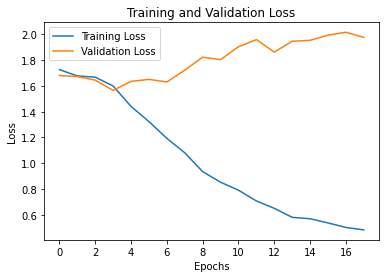

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()